<a href="https://colab.research.google.com/github/mingmingbupt/tensorflow/blob/master/tf_keras_regression_hp_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

1.15.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.2.0
numpy 1.18.2
pandas 0.25.3
sklearn 0.22.2.post1
tensorflow 1.15.0
tensorflow.python.keras.api._v1.keras 2.2.4-tf


In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)


(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [5]:
# learning_rate: [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]
# W = W + grad * learning_rate

#手动实现超参数搜索
#我们只想搜索learning_rate,值为下面6个
#自己实现会有两个缺点
#缺点1： 我们目前比较简单，我们只挑一个参数，现实中可能很多个参数，我们可能会用20层for循环去实现超参数搜索
#缺点2： 这里使用for循环，那就意味着要等一个模型训练完以后才可以训练下一个，这样嗯，就没有并行化的处理
#所以需要借助现有的库实现参数搜索
learning_rates = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]
histories = []
for lr in learning_rates:
    model = keras.models.Sequential([
        keras.layers.Dense(30, activation='relu',
                           input_shape=x_train.shape[1:]),
        keras.layers.Dense(1),
    ])
    # 定义自己的optimizer
    optimizer = keras.optimizers.SGD(lr)
    # 这里使用自己的optimizer
    model.compile(loss="mean_squared_error", optimizer=optimizer)
    callbacks = [keras.callbacks.EarlyStopping(
        patience=5, min_delta=1e-2)]
    # 去训练
    history = model.fit(x_train_scaled, y_train,
                        validation_data = (x_valid_scaled, y_valid),
                        epochs = 100,
                        callbacks = callbacks)
    histories.append(history)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 83us/sample - loss: 5.0118 - val_loss: 4.3486
Epoch 2/100
11610/11610 [==============================] - 0s 41us/sample - loss: 3.5438 - val_loss: 3.1737
Epoch 3/100
11610/11610 [==============================] - 0s 40us/sample - loss: 2.6559 - val_loss: 2.4472
Epoch 4/100
11610/11610 [==============================] - 0s 40us/sample - loss: 2.0885 - val_loss: 1.9741
Epoch 5/100
11610/11610 [==============================] - 0s 40us/sample - loss: 1.7128 - val_loss: 1.6549
Epoch 6/100
11610/11610 [==============================] - 0s 38us/sample - loss: 1.4525 - val_loss: 1.4287
Epoch 7/100
11610/11610 [==============================] - 0s 40us/sample - loss: 1.2639 - val_loss: 1.2626
Epoch 8/100
11610/11610 [==============================] - 0s 39us/sample - loss: 1.1235 - val_loss: 1.1368
Epoch 

Learning rate:  0.0001


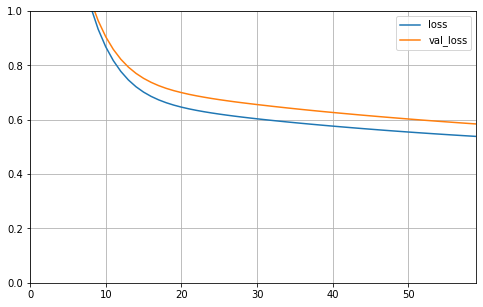

Learning rate:  0.0003


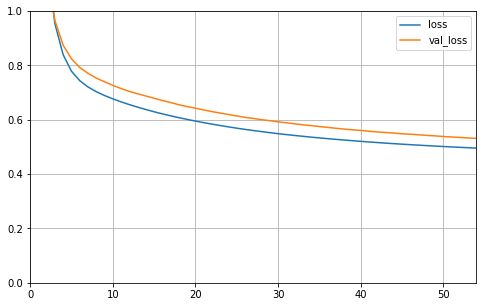

Learning rate:  0.001


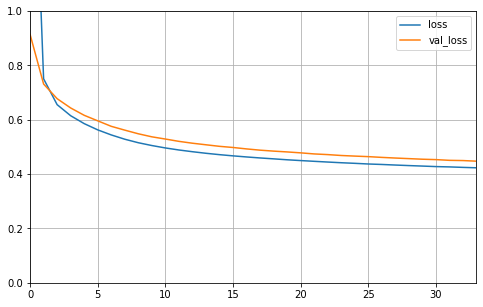

Learning rate:  0.003


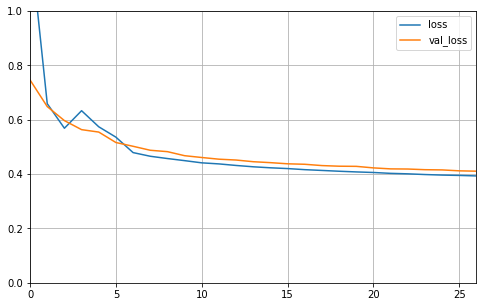

Learning rate:  0.01


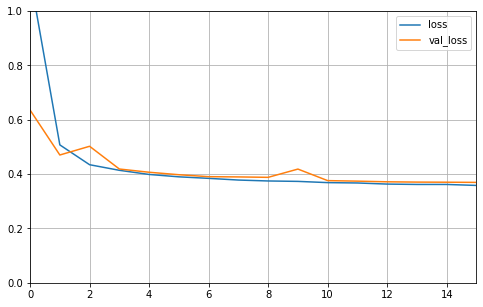

Learning rate:  0.03


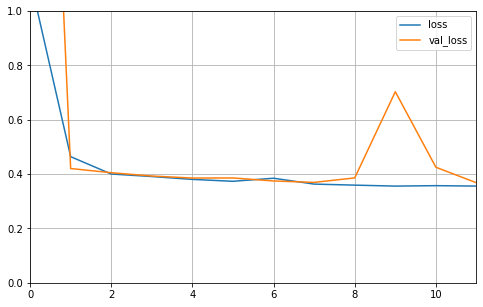

In [6]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
for lr, history in zip(learning_rates, histories):
    print("Learning rate: ", lr)
    plot_learning_curves(history)